<a href="https://colab.research.google.com/github/Banafshehkh/Natural-Language-Processing/blob/main/last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Banafsheh Khazali
# Date: March 01, 2023

# **Semantic Text Similarity on Medical Symptoms** 


In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.spatial import distance_matrix

import os
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.metrics.pairwise import pairwise_distances


## **Scraping the data**

To scrape the data, We can use Python libraries such as BeautifulSoup and requests. 



In [ ]:
# Define the URL of the symptom checker page
url = 'https://www.mayoclinic.org/symptom-checker/select-symptom/itt-20009075'

# Send a GET request to the URL
session = requests.Session()
response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the section of the page that contains adult symptoms
adult_symptoms_section = soup.find('div', {'class': 'adult'})
# Check that the adult symptoms section was found
if adult_symptoms_section:
    # Find all links within the adult symptoms section
    adult_symptom_links = adult_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    adult_symptom_urls = [link['href'] for link in adult_symptom_links]

    


# Find the section of the page that contains child symptoms
child_symptoms_section = soup.find('div', {'class': 'child'})

# Check that the child symptoms section was found
if child_symptoms_section:
    # Find all links within the child symptoms section
    child_symptom_links = child_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    child_symptom_urls = [link['href'] for link in child_symptom_links]



# Print the URLs for the adult symptoms
full_adult_url = []
for i in adult_symptom_urls:
  full_adult_url.append("https://www.mayoclinic.org/"+i)

print('\nAdult Symptom URLs:', full_adult_url)

# Print the URLs for the child symptoms
full_child_urls = []
for i in child_symptom_urls:
  full_child_urls.append("https://www.mayoclinic.org/"+i)

print('\nChild Symptom URLs:', full_child_urls)



Adult Symptom URLs: ['https://www.mayoclinic.org//symptom-checker/abdominal-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/blood-in-stool-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/chest-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/constipation-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/cough-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/diarrhea-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/difficulty-swallowing-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/dizziness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/eye-discomfort-and-redness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclini

In [ ]:
!mkdir corpus

In [ ]:
pwd

'/content'

**extract adult symptoms**

In [ ]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_adult_url):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    adult_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if adult_symptoms_section is not None:
        name = full_adult_url[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(adult_symptoms_section.text)
    else:
        print(f"No 'adult' section found on page {i+1}")

**extract children symptoms**

In [ ]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_child_urls):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    child_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if child_symptoms_section is not None:
        name = full_child_urls[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(child_symptoms_section.text)
    else:
        print(f"No 'child' section found on page {i+1}")

## **Preprocessing the data**

To preprocess the data, We may need to clean and tokenize the text, remove stop words, and perform stemming or lemmatization.

In [ ]:
!mkdir pre_corpus

**Preprocess adult/child files**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Define the directory where the text files are located
corpus_dir_in = 'D:/University/1-Calgary/NLP/Assignment/project/corpus/'
corpus_dir_out = 'D:/University/1-Calgary/NLP/Assignment/project/corpus/pre_corpus'

# Create the output directory if it doesn't exist
if not os.path.exists(corpus_dir_out):
    os.makedirs(corpus_dir_out)


# Loop over the input files
for filename in os.listdir(corpus_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(corpus_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(corpus_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Processed file: shoulder-pain-in-adults.txt
Processed file: diarrhea-in-adults.txt
Processed file: heart-palpitations-in-adults.txt
Processed file: headaches-in-adults.txt
Processed file: numbness-or-tingling-in-hands-in-adults.txt
Processed file: constipation-in-adults.txt
Processed file: blood-in-stool-in-adults.txt
Processed file: chest-pain-in-adults.txt
Processed file: eye-problems-in-adults.txt
Processed file: wheezing-in-adults.txt
Processed file: pelvic-pain-in-adult-males.txt
Processed file: wheezing-in-children.txt
Processed file: nausea-or-vomiting-in-children.txt
Processed file: low-back-pain-in-adults.txt
Processed file: abdominal-pain-in-adults.txt
Processed file: shortness-of-breath-in-adults.txt
Processed file: eye-discomfort-and-redness-in-children.txt
Processed file: dizziness-in-adults.txt
Processed file: cough-in-children.txt
Processed file: foot-swelling-or-leg-swelling-in-adults.txt
Processed file: abdominal-pain-in-children.txt
Processed file: pelvic-pain-in-adul

## **Calculating the similarity**

Calculate the similarity between the two document-term matrices using a similarity metric such as cosine similarity or Jaccard similarity.

In [ ]:
# Define directory path containing text files
dir_path = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
corpus = []
for file_name in file_names:
    with open(os.path.join(dir_path, file_name), 'r') as f:
        text = f.read()
        corpus.append(text)

# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[1.         0.51255555 0.44610981 ... 0.22899668 0.11457446 0.11221198]
 [0.51255555 1.         0.33278885 ... 0.17419749 0.10666602 0.20094765]
 [0.44610981 0.33278885 1.         ... 0.14385978 0.09992165 0.0945775 ]
 ...
 [0.22899668 0.17419749 0.14385978 ... 1.         0.12969669 0.15203967]
 [0.11457446 0.10666602 0.09992165 ... 0.12969669 1.         0.78066893]
 [0.11221198 0.20094765 0.0945775  ... 0.15203967 0.78066893 1.        ]]


##  Visualize the similarity results using a heatmap or a dendrogram

The dendrogram shows the hierarchical clustering of the documents based on their similarity.

The heatmap shows the similarity matrix as a color-coded grid, where darker colors indicate higher similarity. 

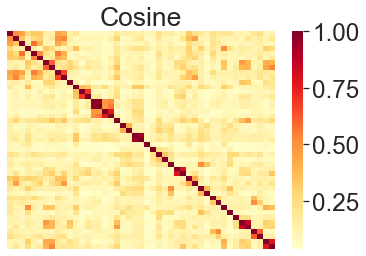

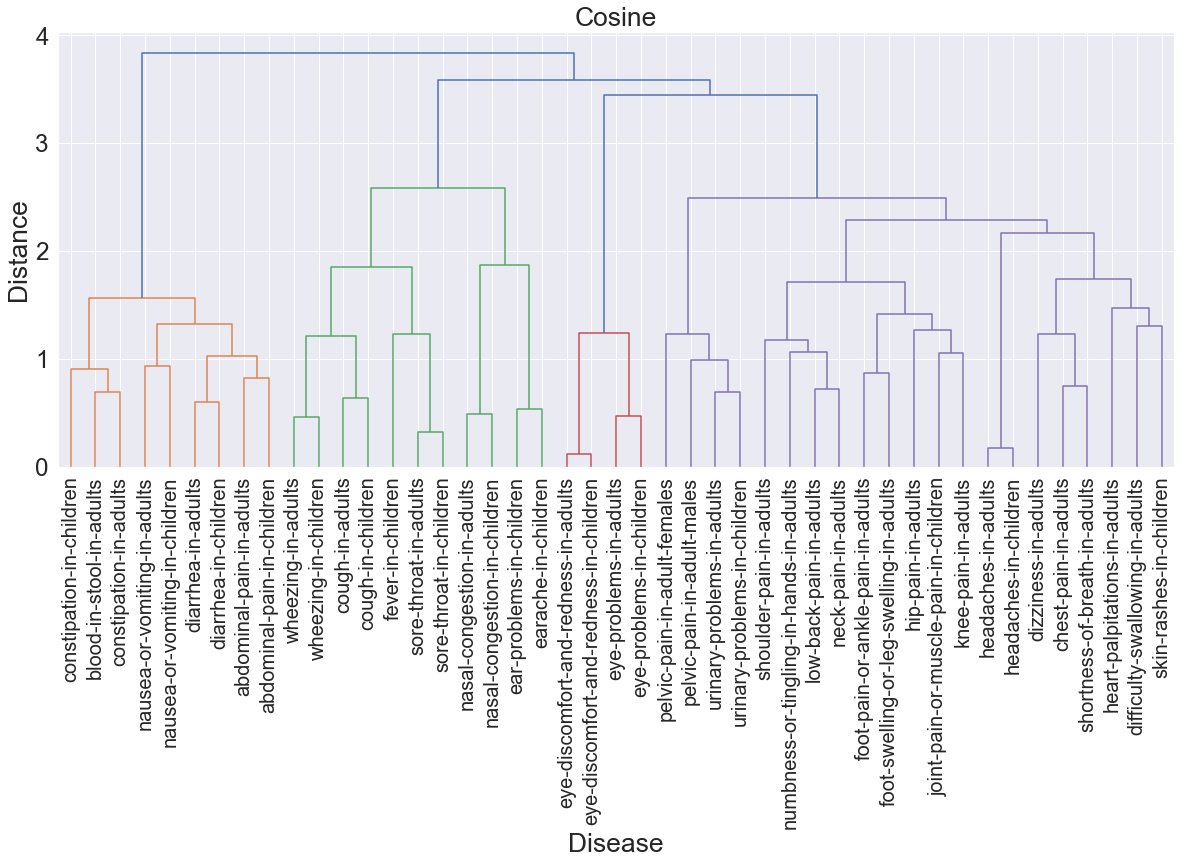

In [ ]:
# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Cosine')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Cosine')
plt.xlabel('Disease')
plt.ylabel('Distance')
plt.show()

## **Find Similar Diseases**

Using clustering algorithms such as K-means clustering or Hierarchical clustering to find similar diseases in the document.

In [ ]:
# Cluster documents using K-means
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# Print the top 5 documents in each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_indices = np.where(km.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:5]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(dir_path)[cluster_indices[j]]}")      

Cluster 0:
- Document 7: cough-in-children.txt
- Document 6: cough-in-adults.txt
- Document 44: wheezing-in-children.txt
- Document 39: sore-throat-in-adults.txt
- Document 40: sore-throat-in-children.txt
Cluster 1:
- Document 8: diarrhea-in-adults.txt
- Document 0: abdominal-pain-in-adults.txt
- Document 9: diarrhea-in-children.txt
- Document 4: constipation-in-adults.txt
- Document 1: abdominal-pain-in-children.txt
Cluster 2:
- Document 15: eye-discomfort-and-redness-in-children.txt
- Document 14: eye-discomfort-and-redness-in-adults.txt
- Document 17: eye-problems-in-children.txt
- Document 16: eye-problems-in-adults.txt
- Document 22: headaches-in-children.txt


Clustering Methods:

*   Agglomerative Hierarchical Clustering
*   DBSCAN
*   Spectral Clustering
*   Spectral Clustering
*   Affinity Propagation

Distance Metrics:


*   Euclidean Distance

*   Manhattan Distance
*   Cosine Similarity


*   Jaccard Similarity







In [ ]:
# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = 1 - cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[ 2.22044605e-16  4.87444450e-01  5.53890191e-01 ...  7.71003321e-01
   8.85425536e-01  8.87788016e-01]
 [ 4.87444450e-01 -2.22044605e-16  6.67211146e-01 ...  8.25802508e-01
   8.93333979e-01  7.99052347e-01]
 [ 5.53890191e-01  6.67211146e-01 -2.22044605e-16 ...  8.56140220e-01
   9.00078353e-01  9.05422504e-01]
 ...
 [ 7.71003321e-01  8.25802508e-01  8.56140220e-01 ... -2.22044605e-16
   8.70303310e-01  8.47960333e-01]
 [ 8.85425536e-01  8.93333979e-01  9.00078353e-01 ...  8.70303310e-01
  -6.66133815e-16  2.19331069e-01]
 [ 8.87788016e-01  7.99052347e-01  9.05422504e-01 ...  8.47960333e-01
   2.19331069e-01  6.66133815e-16]]


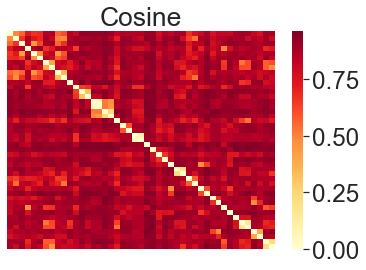

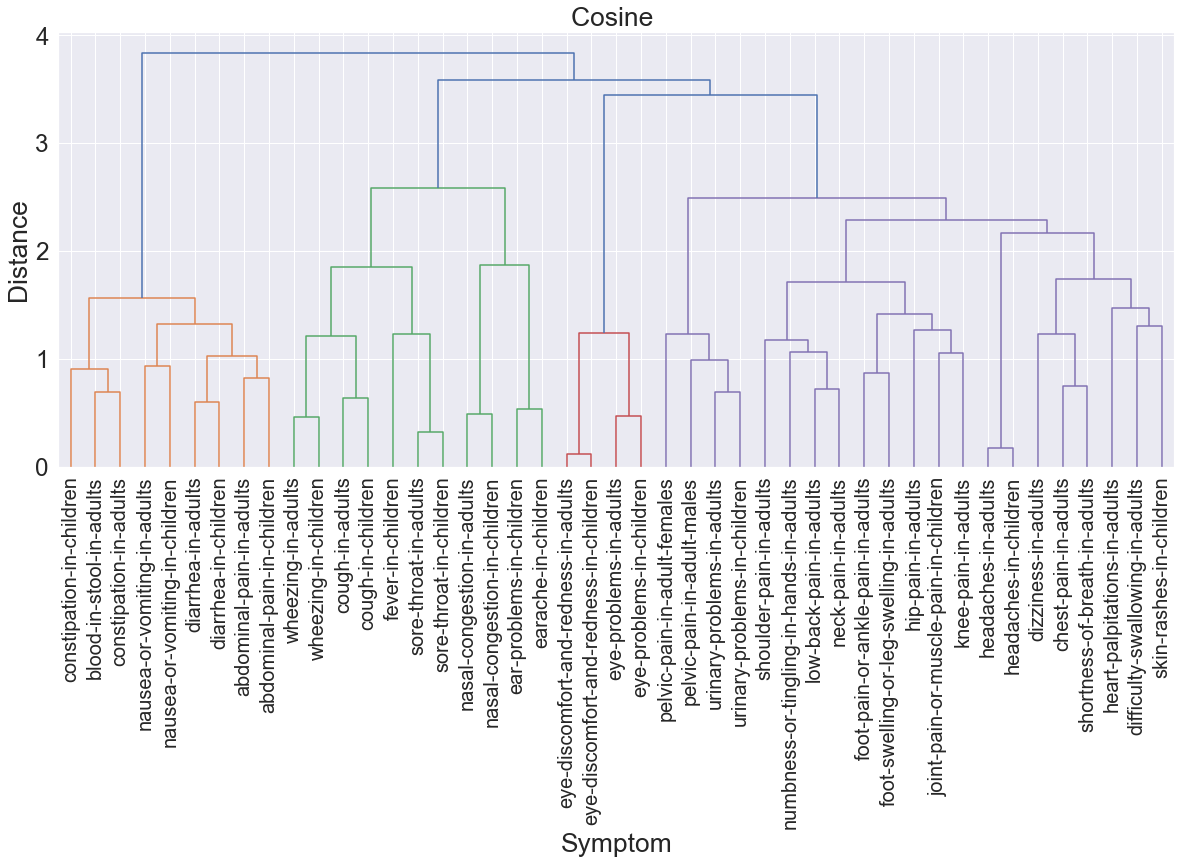

In [ ]:
# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Cosine')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Cosine ')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

jaccard similarity

[[1.         0.40625    0.34899329 ... 0.25641026 0.19251337 0.17924528]
 [0.40625    1.         0.31468531 ... 0.23648649 0.18644068 0.20304569]
 [0.34899329 0.31468531 1.         ... 0.29268293 0.22368421 0.17032967]
 ...
 [0.25641026 0.23648649 0.29268293 ... 1.         0.25694444 0.21637427]
 [0.19251337 0.18644068 0.22368421 ... 0.25694444 1.         0.63194444]
 [0.17924528 0.20304569 0.17032967 ... 0.21637427 0.63194444 1.        ]]


C:\Python310\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


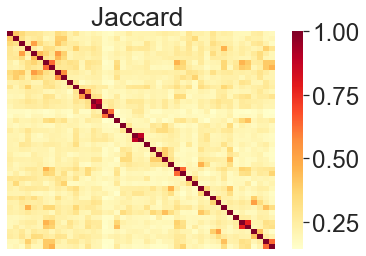

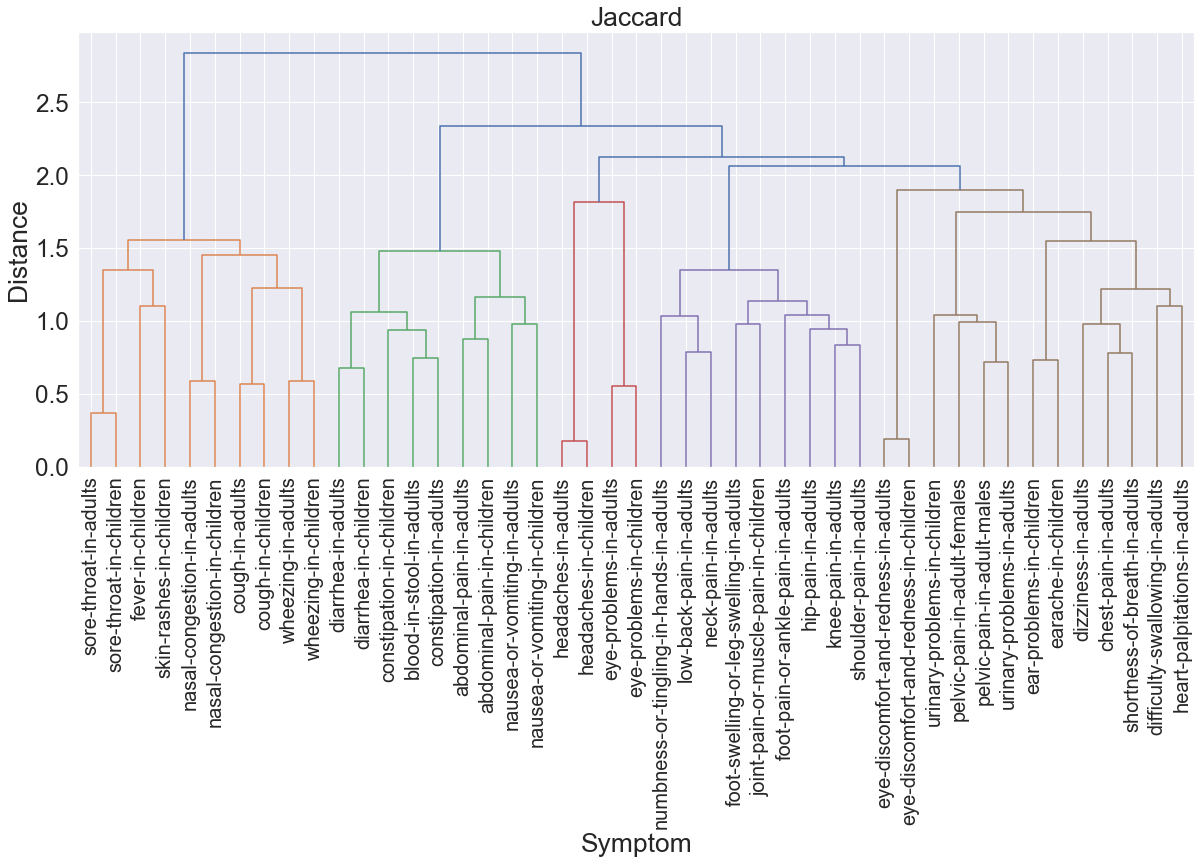

In [ ]:
# Create a TfidfVectorizer with the Jaccard similarity metric
vectorizer = TfidfVectorizer(use_idf=False, norm='l2', binary=True)
tfidf_matrix = vectorizer.fit_transform(corpus)

# Convert the sparse matrix to a dense matrix
dense_matrix = tfidf_matrix.toarray()

# Calculate the pairwise Jaccard similarity matrix
jaccard_similarity_matrix = 1 - pairwise_distances(dense_matrix, metric='jaccard')

# Print the pairwise Jaccard similarity matrix
print(jaccard_similarity_matrix)



# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(jaccard_similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Jaccard ')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(jaccard_similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Jaccard')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

### manhatan

[[0.         1.07902501 1.26112144 ... 1.53635847 1.66368422 1.67285835]
 [1.07902501 0.         1.36217883 ... 1.58740892 1.6732075  1.59102927]
 [1.26112144 1.36217883 0.         ... 1.53475377 1.63509287 1.74749636]
 ...
 [1.53635847 1.58740892 1.53475377 ... 0.         1.57848781 1.63848257]
 [1.66368422 1.6732075  1.63509287 ... 1.57848781 0.         0.70455389]
 [1.67285835 1.59102927 1.74749636 ... 1.63848257 0.70455389 0.        ]]


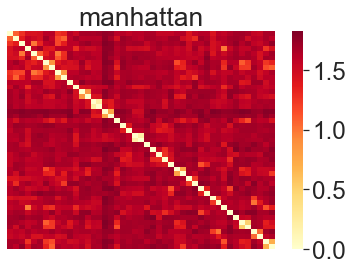

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\2156318824.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(manhattan_distance_matrix, method='ward'), labels =f_names )


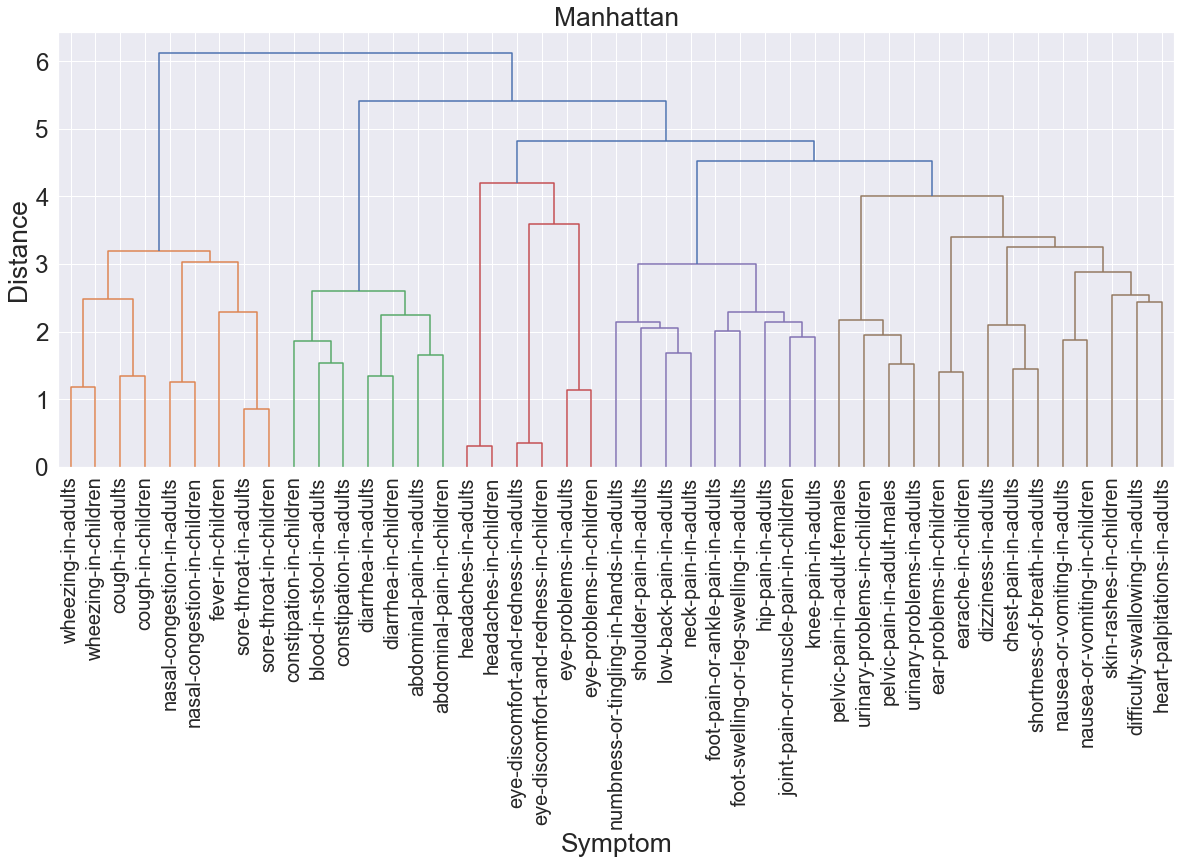

In [ ]:
# Create a TfidfVectorizer with the Manhattan distance metric
vectorizer = TfidfVectorizer(use_idf=True, norm='l1')
tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Manhattan distance matrix
manhattan_distance_matrix = pairwise_distances(tfidf_matrix, metric='manhattan')

# Print the pairwise Manhattan distance matrix
print(manhattan_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(manhattan_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('manhattan')
plt.show()



# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(manhattan_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Manhattan')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

### Euclidean Distance

[[ 0.         13.56465997 14.07124728 ... 16.30950643 18.86796226
  20.88061302]
 [13.56465997  0.         14.76482306 ... 16.         17.54992877
  18.43908891]
 [14.07124728 14.76482306  0.         ... 16.673332   17.60681686
  20.09975124]
 ...
 [16.30950643 16.         16.673332   ...  0.         16.73320053
  18.65475811]
 [18.86796226 17.54992877 17.60681686 ... 16.73320053  0.
  10.09950494]
 [20.88061302 18.43908891 20.09975124 ... 18.65475811 10.09950494
   0.        ]]


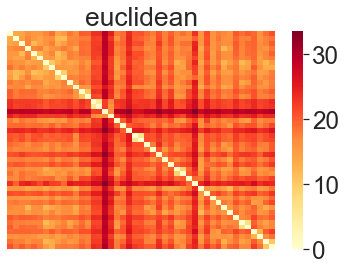

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\174621247.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )


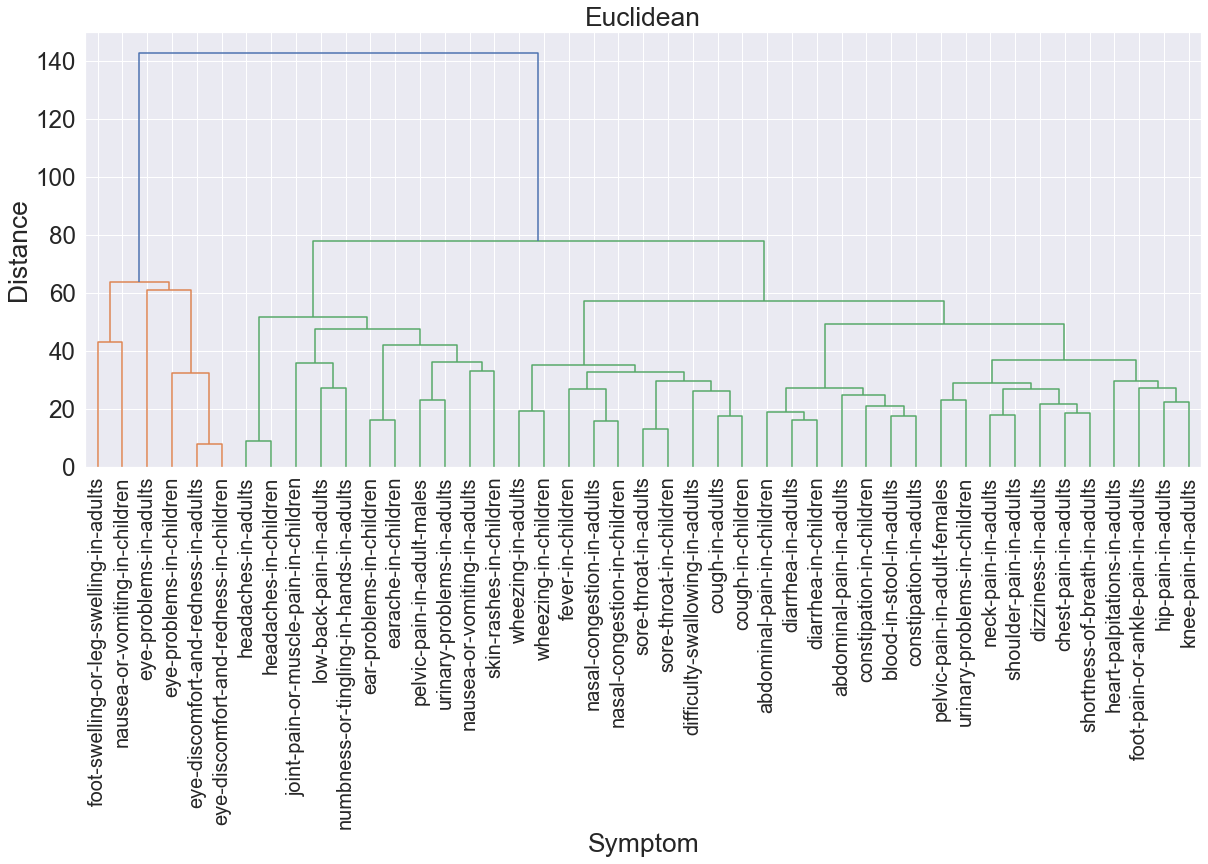

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the corpus
doc_term_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Euclidean distance matrix
euclidean_distance_matrix = pairwise_distances(doc_term_matrix, metric='euclidean')

# Print the pairwise Euclidean distance matrix
print(euclidean_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(euclidean_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('euclidean')
plt.show()

# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Euclidean')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()



### Clustering

In [ ]:
import os
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation

# set the path to the folder containing the documents
folder_path = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# define a function to preprocess the text
def preprocess_text(text):
    # remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # convert to lowercase
    text = text.lower()
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

# read the documents from the folder and preprocess them
docs = []
for file_name in os.listdir(folder_path):
    with open(os.path.join(folder_path, file_name), 'r') as file:
        doc = file.read()
        doc = preprocess_text(doc)
        docs.append(doc)

# create a tf-idf matrix for the documents
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

# perform clustering using Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_clustering.fit(tfidf_matrix.toarray())
agg_labels = agg_clustering.labels_
agg_centroids = np.zeros((2, tfidf_matrix.shape[1]))
for i in range(2):
    agg_centroids[i] = np.mean(tfidf_matrix.toarray()[agg_labels == i], axis=0)

# perform clustering using DBSCAN
dbscan_clustering = DBSCAN(eps=0.5, min_samples=2)
dbscan_clustering.fit(tfidf_matrix.toarray())
dbscan_labels = dbscan_clustering.labels_

# perform clustering using Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=2, assign_labels='discretize')
spectral_clustering.fit(tfidf_matrix)
spectral_labels = spectral_clustering.labels_
spectral_centroids = np.zeros((2, tfidf_matrix.shape[1]))
for i in range(2):
    spectral_centroids[i] = np.mean(tfidf_matrix.toarray()[spectral_labels == i], axis=0)

# perform clustering using Affinity Propagation
affinity_propagation = AffinityPropagation(damping=0.5)
affinity_propagation.fit(tfidf_matrix.toarray())
affinity_labels = affinity_propagation.labels_
affinity_centroids = np.zeros((len(set(affinity_labels)), tfidf_matrix.shape[1]))
for i in range(len(set(affinity_labels))):
    affinity_centroids[i] = np.mean(tfidf_matrix.toarray()[affinity_labels == i], axis=0)

# print the clustering results
print('Agglomerative Hierarchical Clustering:')
print(agg_labels)
print(agg_centroids)
print('DBSCAN:')
print(dbscan_labels)
print('Spectral Clustering:')
print(spectral_labels)
print(spectral_centroids)
print('Affinity Propagation:')
print(affinity_labels)
print(affinity_centroids)


Agglomerative Hierarchical Clustering:
[1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0]
[[0.00796911 0.00748232 0.0063703  ... 0.01284309 0.0049584  0.00355235]
 [0.07867349 0.18545412 0.         ... 0.         0.01175869 0.        ]]
DBSCAN:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Spectral Clustering:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[[0.         0.         0.01967021 ... 0.         0.         0.02131407]
 [0.02551152 0.04970386 0.00285409 ... 0.01185516 0.00729053 0.        ]]
Affinity Propagation:
[ 0  0  0  8  0  0 11 11  0  0  9  1  1  1  2  2  2  2  9  3  3  4  4  8
  5  5  5  7  6  6  0  0  7  7 10 10  8  7  5  9  9 10 10 11 11]
[[0.07867349 0.18545412 0.         ... 0.         0.01175869 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.    

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)


for i in range(4):
    print(f"Cluster {i}:")
    affinity_propagation = AffinityPropagation(damping=0.5)
    affinity_propagation.fit(tfidf_matrix.toarray())
    similarity_matrix = distance_matrix(tfidf_matrix.toarray(), tfidf_matrix.toarray())
    cluster_indices = np.where(agg_clustering.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:20]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(folder_path)[int(cluster_indices[j])]}")

### output examples for AgglomerativeClustering 

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)


for i in range(12):
    print(f"Cluster {i}:")
    affinity_propagation = AffinityPropagation(damping=0.5)
    affinity_propagation.fit(tfidf_matrix.toarray())
    similarity_matrix = distance_matrix(tfidf_matrix.toarray(), tfidf_matrix.toarray())
    cluster_indices = np.where(affinity_propagation.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:20]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(folder_path)[int(cluster_indices[j])]}")

Cluster 0:
- Document 30: nausea-or-vomiting-in-adults.txt
- Document 31: nausea-or-vomiting-in-children.txt
- Document 5: constipation-in-children.txt
- Document 2: blood-in-stool-in-adults.txt
- Document 0: abdominal-pain-in-adults.txt
- Document 4: constipation-in-adults.txt
- Document 1: abdominal-pain-in-children.txt
- Document 9: diarrhea-in-children.txt
- Document 8: diarrhea-in-adults.txt
Cluster 1:
- Document 11: dizziness-in-adults.txt
- Document 13: earache-in-children.txt
- Document 12: ear-problems-in-children.txt
Cluster 2:
- Document 16: eye-problems-in-adults.txt
- Document 17: eye-problems-in-children.txt
- Document 14: eye-discomfort-and-redness-in-adults.txt
- Document 15: eye-discomfort-and-redness-in-children.txt
Cluster 3:
- Document 19: foot-pain-or-ankle-pain-in-adults.txt
- Document 20: foot-swelling-or-leg-swelling-in-adults.txt
Cluster 4:
- Document 21: headaches-in-adults.txt
- Document 22: headaches-in-children.txt
Cluster 5:
- Document 38: skin-rashes-in-c

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)
num_of_clusters = 10
np.random.seed(102)

for i in range(num_of_clusters):
    print(f"Cluster {i}:")
    spectral_clustering = SpectralClustering(n_clusters=num_of_clusters , assign_labels='discretize', random_state= 0)
    spectral_clustering.fit(tfidf_matrix)
    similarity_matrix = distance_matrix(tfidf_matrix.toarray(), tfidf_matrix.toarray())
    cluster_indices = np.where(spectral_clustering.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:20]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(folder_path)[int(cluster_indices[j])]}")

Cluster 0:
- Document 23: heart-palpitations-in-adults.txt
- Document 11: dizziness-in-adults.txt
- Document 3: chest-pain-in-adults.txt
Cluster 1:
- Document 38: skin-rashes-in-children.txt
- Document 24: hip-pain-in-adults.txt
- Document 26: knee-pain-in-adults.txt
- Document 33: numbness-or-tingling-in-hands-in-adults.txt
- Document 37: shoulder-pain-in-adults.txt
- Document 19: foot-pain-or-ankle-pain-in-adults.txt
- Document 20: foot-swelling-or-leg-swelling-in-adults.txt
- Document 25: joint-pain-or-muscle-pain-in-children.txt
- Document 27: low-back-pain-in-adults.txt
- Document 32: neck-pain-in-adults.txt
Cluster 2:
- Document 28: nasal-congestion-in-adults.txt
- Document 29: nasal-congestion-in-children.txt
Cluster 3:
- Document 34: pelvic-pain-in-adult-females.txt
- Document 42: urinary-problems-in-children.txt
- Document 35: pelvic-pain-in-adult-males.txt
- Document 41: urinary-problems-in-adults.txt
Cluster 4:
- Document 36: shortness-of-breath-in-adults.txt
- Document 6: c

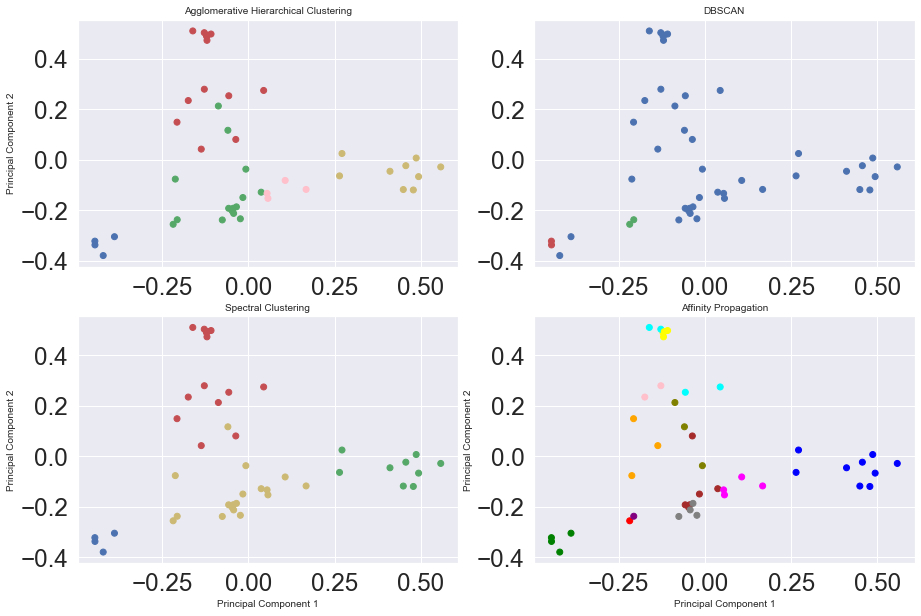

In [ ]:
import os
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# set the path to the folder containing the documents
folder_path = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# define a function to preprocess the text
def preprocess_text(text):
    # remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # convert to lowercase
    text = text.lower()
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

# read the documents from the folder and preprocess them
docs = []
for file_name in os.listdir(folder_path):
    with open(os.path.join(folder_path, file_name), 'r') as file:
        doc = file.read()
        doc = preprocess_text(doc)
        docs.append(doc)

# create a tf-idf matrix for the documents
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

# reduce the dimensionality of the tf-idf matrix using PCA
pca = PCA(n_components=3)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# perform clustering using Agglomerative Hierarchical Clustering
np.random.seed(102)
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_clustering.fit(tfidf_matrix.toarray())
agg_labels = agg_clustering.labels_
agg_centroids = np.zeros((5, tfidf_matrix.shape[1]))
for i in range(5):
    agg_centroids[i] = np.mean(tfidf_matrix.toarray()[agg_labels == i], axis=0)

# perform clustering using DBSCAN
dbscan_clustering = DBSCAN(eps=0.5, min_samples=2)
dbscan_clustering.fit(tfidf_matrix.toarray())
dbscan_labels = dbscan_clustering.labels_

# perform clustering using Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=4, assign_labels='discretize')
spectral_clustering.fit(tfidf_matrix)
spectral_labels = spectral_clustering.labels_
spectral_centroids = np.zeros((3, tfidf_matrix.shape[1]))
for i in range(3):
    spectral_centroids[i] = np.mean(tfidf_matrix.toarray()[spectral_labels == i], axis=0)

# perform clustering using Affinity Propagation
affinity_propagation = AffinityPropagation(damping=0.9)
affinity_propagation.fit(tfidf_matrix.toarray())
affinity_labels = affinity_propagation.labels_
affinity_centroids = np.zeros((len(set(affinity_labels)), tfidf_matrix.shape[1]))
for i in range(len(set(affinity_labels))):
    affinity_centroids[i] = np.mean(tfidf_matrix.toarray()[affinity_labels == i], axis=0)

# plot the clustering results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Agglomerative Hierarchical Clustering
colors = ['r', 'g', 'b', 'y','pink', 'black']
color_list = [colors[label] for label in agg_labels] 
axs[0, 0].scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=color_list)
# axs[0, 0].scatter(agg_centroids[:, 0], agg_centroids[:, 1], c='red',marker='*', s=200)

# add title and axis labels
axs[0, 0].set_title('Agglomerative Hierarchical Clustering',fontsize=10)
# axs[0, 0].set_xlabel('Principal Component 1',fontsize=10)
axs[0, 0].set_ylabel('Principal Component 2',fontsize=10)

# DBSCAN
colors = ['r', 'g', 'b']
color_list = [colors[label] for label in dbscan_labels] 
axs[0, 1].scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=color_list)
axs[0, 1].set_title('DBSCAN',fontsize=10)
# axs[0, 1].set_xlabel('Principal Component 1',fontsize=10)
# axs[0, 1].set_ylabel('Principal Component 2',fontsize=10)

# Spectral Clustering
colors = ['r', 'g', 'b', 'y','pink', 'black']
color_list = [colors[label] for label in spectral_labels] 
axs[1, 0].scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=color_list)
# axs[1, 0].scatter(spectral_centroids[:, 0], spectral_centroids[:, 1], c='red', marker='*', s=200)
axs[1, 0].set_title('Spectral Clustering',fontsize=10)
axs[1, 0].set_xlabel('Principal Component 1',fontsize=10)
axs[1, 0].set_ylabel('Principal Component 2',fontsize=10)

# Affinity Propagation
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown','pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']
color_list = [colors[label] for label in affinity_labels] 
axs[1, 1].scatter(pca_matrix[:, 0], pca_matrix[:, 1], c=color_list)
# axs[1, 1].scatter(affinity_centroids[:, 0], affinity_centroids[:, 1], c='red', marker='*', s=200)
axs[1, 1].set_title('Affinity Propagation', fontsize=10)
axs[1, 1].set_xlabel('Principal Component 1', fontsize=10)
axs[1, 1].set_ylabel('Principal Component 2',fontsize=10)

# show the plot
plt.show()

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\4231278155.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  agg_linkage_matrix = linkage(similarity_matrix, method='ward')


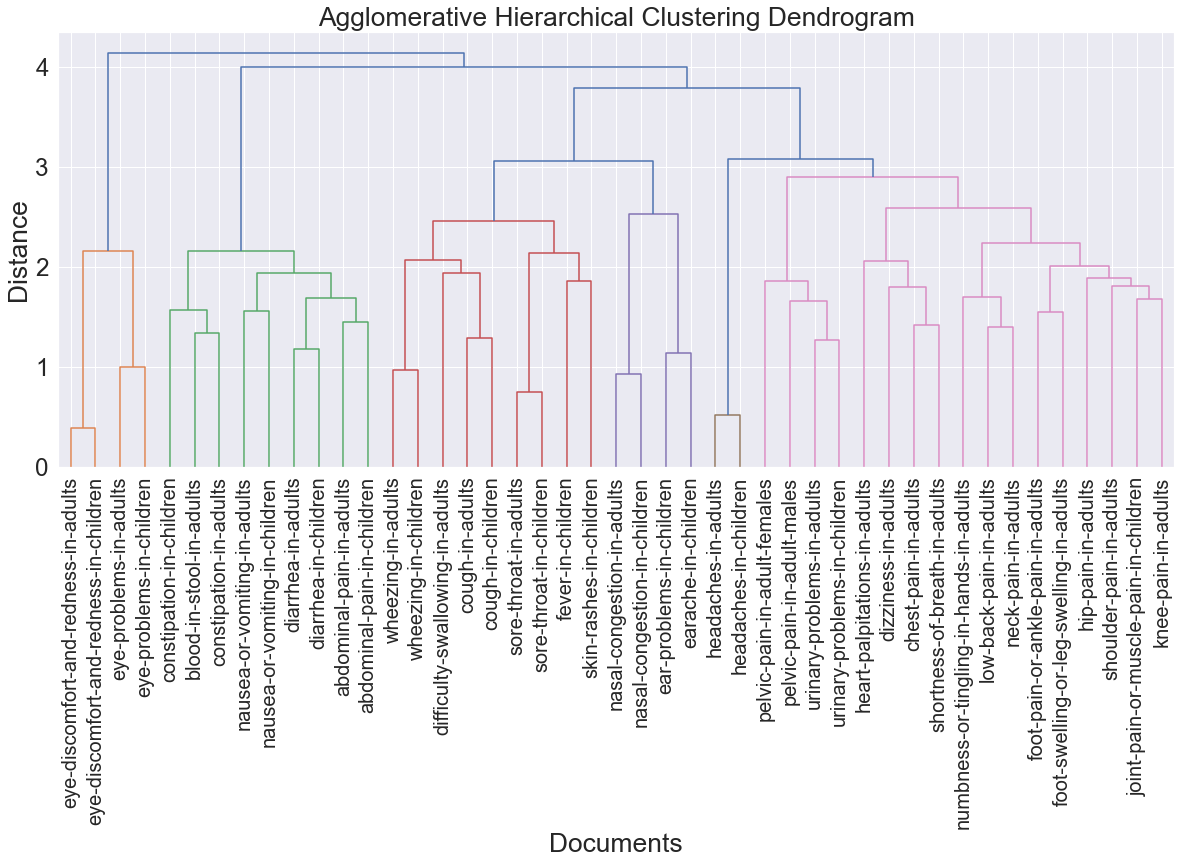

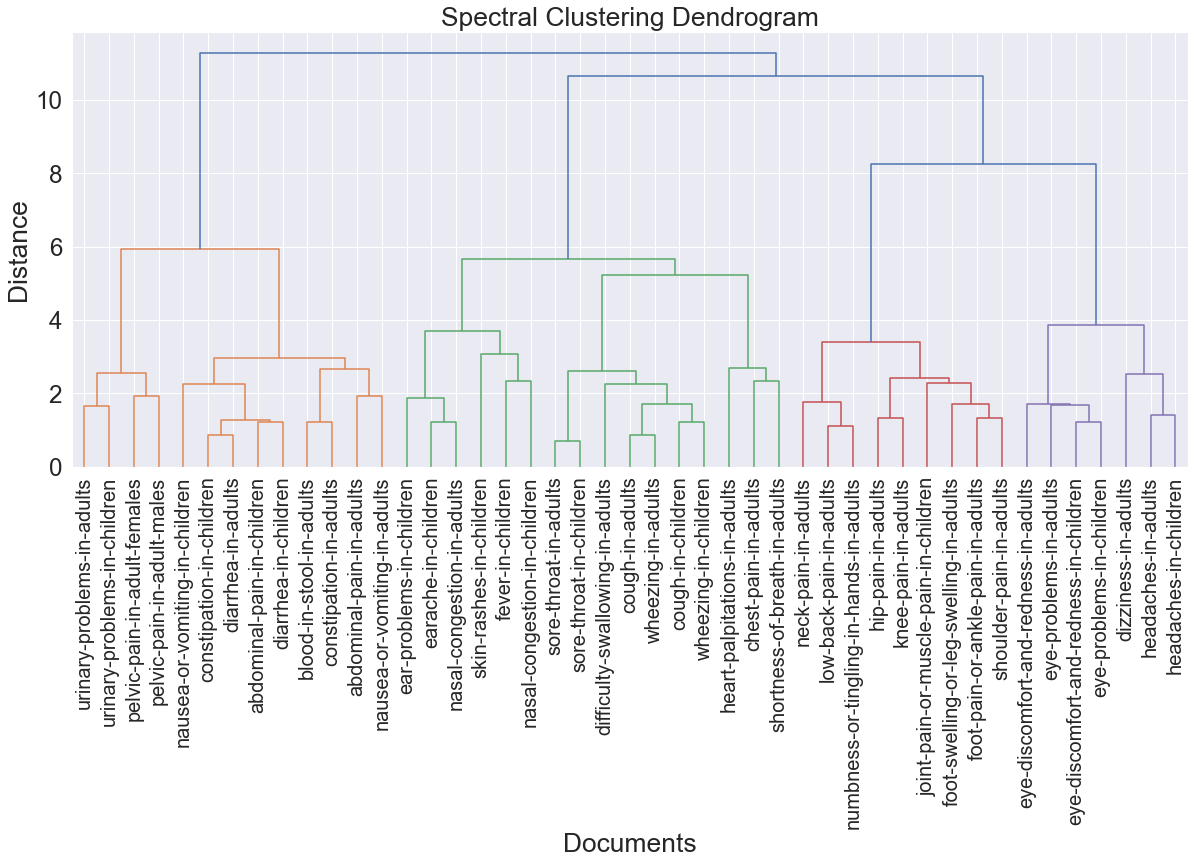

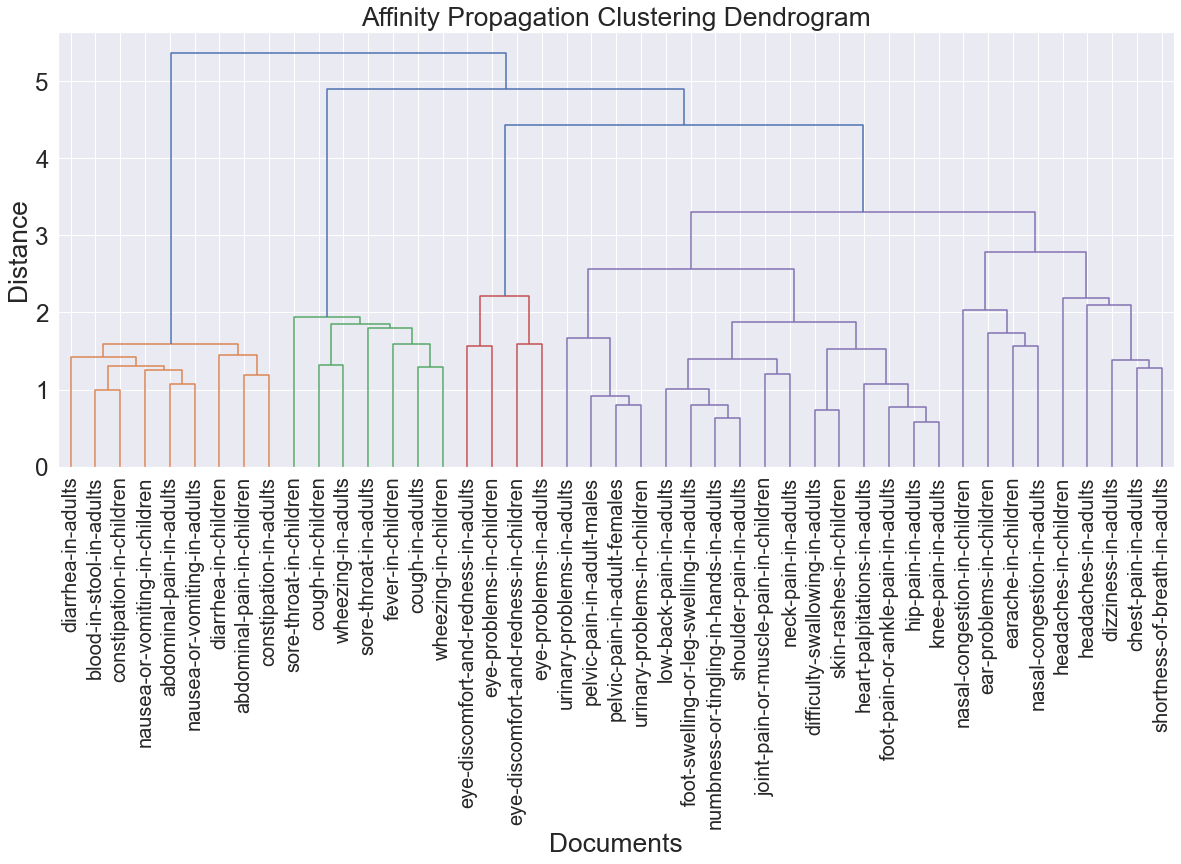

45

In [ ]:
import os
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# set the path to the folder containing the documents
folder_path = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# define a function to preprocess the text
def preprocess_text(text):
    # remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # convert to lowercase
    text = text.lower()
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

# read the documents from the folder and preprocess them
docs = []
for file_name in os.listdir(folder_path):
    with open(os.path.join(folder_path, file_name), 'r') as file:
        doc = file.read()
        doc = preprocess_text(doc)
        docs.append(doc)

# create a tf-idf matrix for the documents
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)
similarity_matrix = distance_matrix(tfidf_matrix.toarray(), tfidf_matrix.toarray())

# perform clustering using Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=6, linkage='ward')
agg_clustering.fit(tfidf_matrix.toarray())
agg_labels = agg_clustering.labels_

# create a dendrogram for Agglomerative Hierarchical Clustering
agg_linkage_matrix = linkage(similarity_matrix, method='ward')
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram(agg_linkage_matrix, labels= f_names)
plt.xticks(fontsize= 20)
plt.title("Agglomerative Hierarchical Clustering Dendrogram")
plt.xlabel("Documents")
plt.ylabel("Distance")
plt.show()


# perform clustering using Spectral Clustering
f_names = [i.split('.')[0] for i in file_names]
spectral_clustering = SpectralClustering(n_clusters=6, assign_labels='discretize', affinity='nearest_neighbors')
spectral_clustering.fit(tfidf_matrix)
spectral_labels = spectral_clustering.labels_
similarity_matrix = -spectral_clustering.affinity_matrix_

# # create a dendrogram for Spectral Clustering

spectral_linkage_matrix = linkage(similarity_matrix.toarray(), method='ward')
plt.figure(figsize=(20, 8))
dendrogram(spectral_linkage_matrix, labels= f_names)
plt.xticks(fontsize= 20)
plt.title("Spectral Clustering Dendrogram")
plt.xlabel("Documents")
plt.ylabel("Distance")
plt.show()


affinity_propagation = AffinityPropagation(damping=0.9)
affinity_propagation.fit(tfidf_matrix.toarray())
affinity_labels = affinity_propagation.labels_
similarity_matrix = -affinity_propagation.affinity_matrix_

affinity_propagation_matrix = linkage(similarity_matrix, method='ward')
plt.figure(figsize=(20, 8))
dendrogram(affinity_propagation_matrix, labels= f_names)
plt.xticks(fontsize= 20)
plt.title("Affinity Propagation Clustering Dendrogram")
plt.xlabel("Documents")
plt.ylabel("Distance")
plt.show()
len(f_names)

# **BAG OF WORDS**

Euclidean with bag of words

[[ 0.         13.56465997 14.07124728 ... 16.30950643 18.86796226
  20.88061302]
 [13.56465997  0.         14.76482306 ... 16.         17.54992877
  18.43908891]
 [14.07124728 14.76482306  0.         ... 16.673332   17.60681686
  20.09975124]
 ...
 [16.30950643 16.         16.673332   ...  0.         16.73320053
  18.65475811]
 [18.86796226 17.54992877 17.60681686 ... 16.73320053  0.
  10.09950494]
 [20.88061302 18.43908891 20.09975124 ... 18.65475811 10.09950494
   0.        ]]


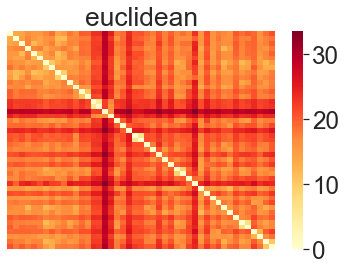

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\3766748215.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )


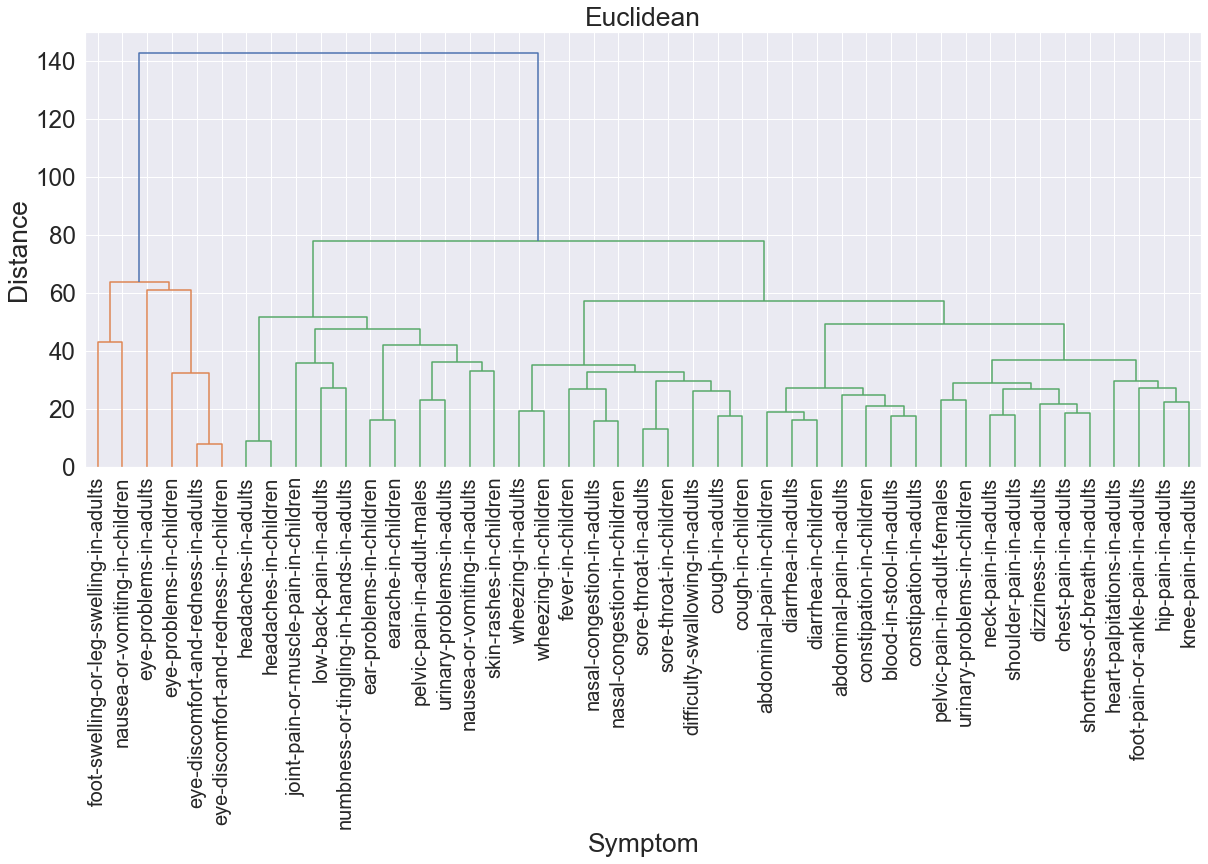

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the corpus
doc_term_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Euclidean distance matrix
euclidean_distance_matrix = pairwise_distances(doc_term_matrix, metric='euclidean')

# Print the pairwise Euclidean distance matrix
print(euclidean_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(euclidean_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('euclidean')
plt.show()

# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Euclidean')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()


[[  0. 132. 134. ... 170. 202. 236.]
 [132.   0. 136. ... 160. 188. 208.]
 [134. 136.   0. ... 142. 164. 210.]
 ...
 [170. 160. 142. ...   0. 154. 192.]
 [202. 188. 164. ... 154.   0.  70.]
 [236. 208. 210. ... 192.  70.   0.]]


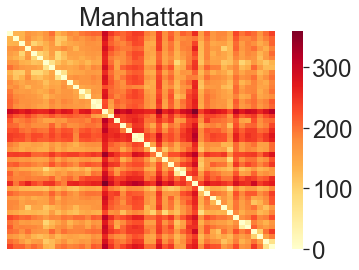

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\1602075196.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )


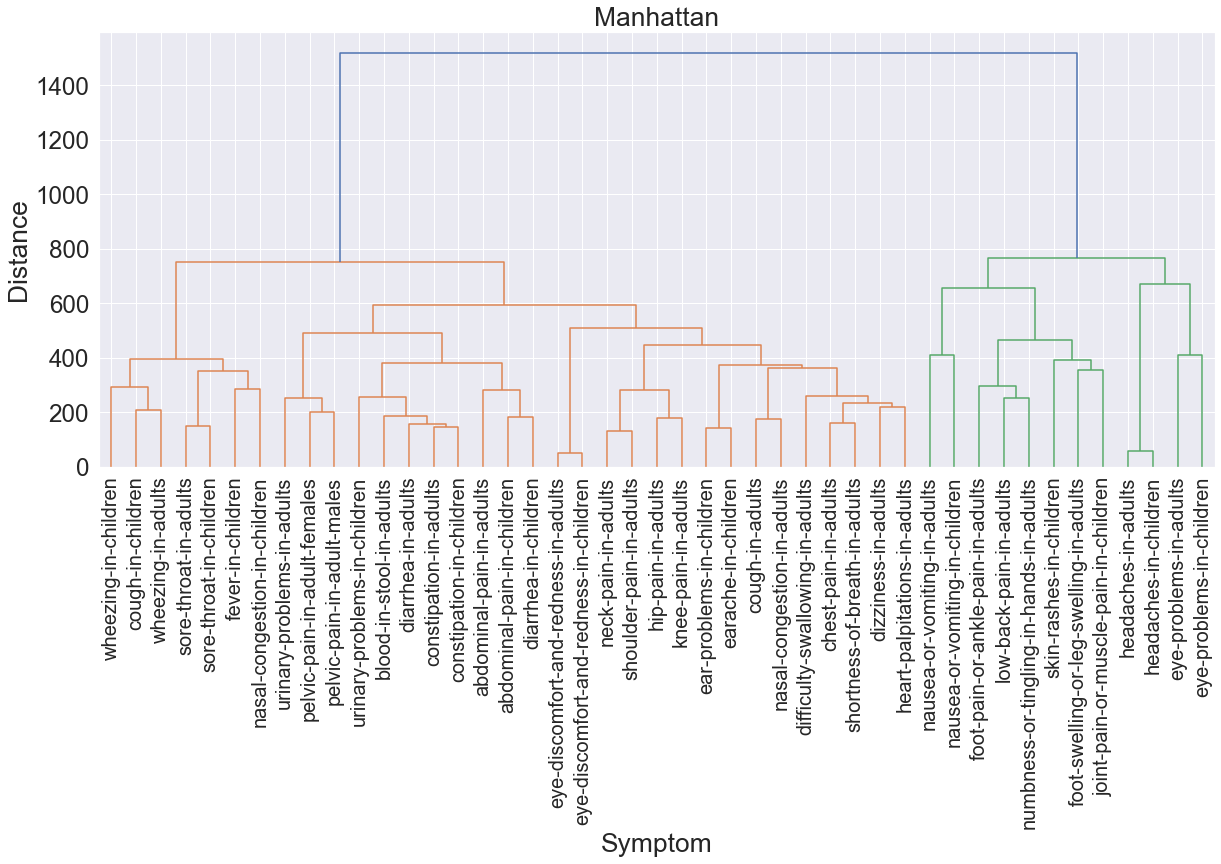

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the corpus
doc_term_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Euclidean distance matrix
euclidean_distance_matrix = pairwise_distances(doc_term_matrix, metric='manhattan')

# Print the pairwise Euclidean distance matrix
print(euclidean_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(euclidean_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Manhattan')
plt.show()

# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Manhattan')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()


[[0.         0.3365808  0.35894261 ... 0.50053996 0.67239775 0.68971801]
 [0.3365808  0.         0.4657339  ... 0.57127474 0.6843665  0.60558717]
 [0.35894261 0.4657339  0.         ... 0.60927313 0.67660604 0.71279453]
 ...
 [0.50053996 0.57127474 0.60927313 ... 0.         0.63926565 0.63238855]
 [0.67239775 0.6843665  0.67660604 ... 0.63926565 0.         0.17104141]
 [0.68971801 0.60558717 0.71279453 ... 0.63238855 0.17104141 0.        ]]


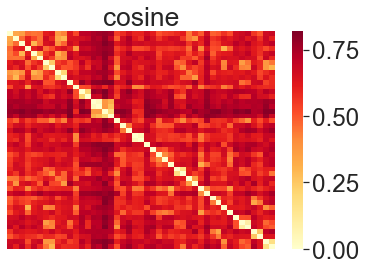

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\2976928804.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )


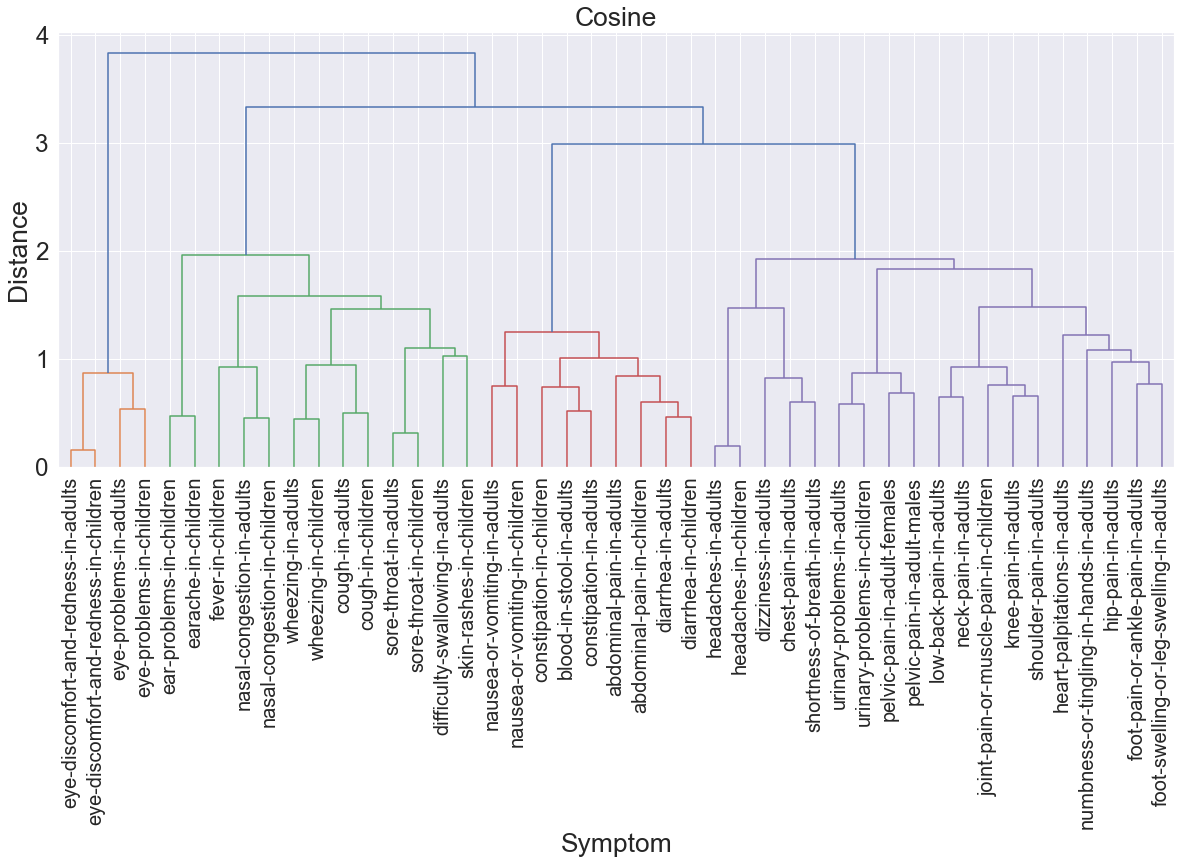

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the corpus
doc_term_matrix = vectorizer.fit_transform(corpus)

# Calculate the pairwise Euclidean distance matrix
euclidean_distance_matrix = pairwise_distances(doc_term_matrix, metric='cosine')

# Print the pairwise Euclidean distance matrix
print(euclidean_distance_matrix)

# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(euclidean_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('cosine')
plt.show()

# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(euclidean_distance_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Cosine')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()


C:\Python310\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


[[0.         0.59375    0.65100671 ... 0.74358974 0.80748663 0.82075472]
 [0.59375    0.         0.68531469 ... 0.76351351 0.81355932 0.79695431]
 [0.65100671 0.68531469 0.         ... 0.70731707 0.77631579 0.82967033]
 ...
 [0.74358974 0.76351351 0.70731707 ... 0.         0.74305556 0.78362573]
 [0.80748663 0.81355932 0.77631579 ... 0.74305556 0.         0.36805556]
 [0.82075472 0.79695431 0.82967033 ... 0.78362573 0.36805556 0.        ]]


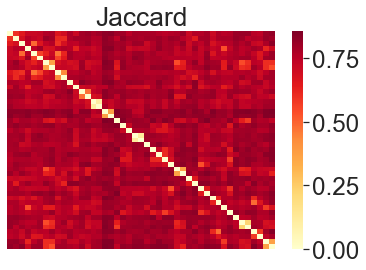

C:\Users\shoko\AppData\Local\Temp\ipykernel_15392\917937214.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = hierarchy.dendrogram(hierarchy.linkage(jaccard_distance_matrix, method='ward'), labels=f_names)


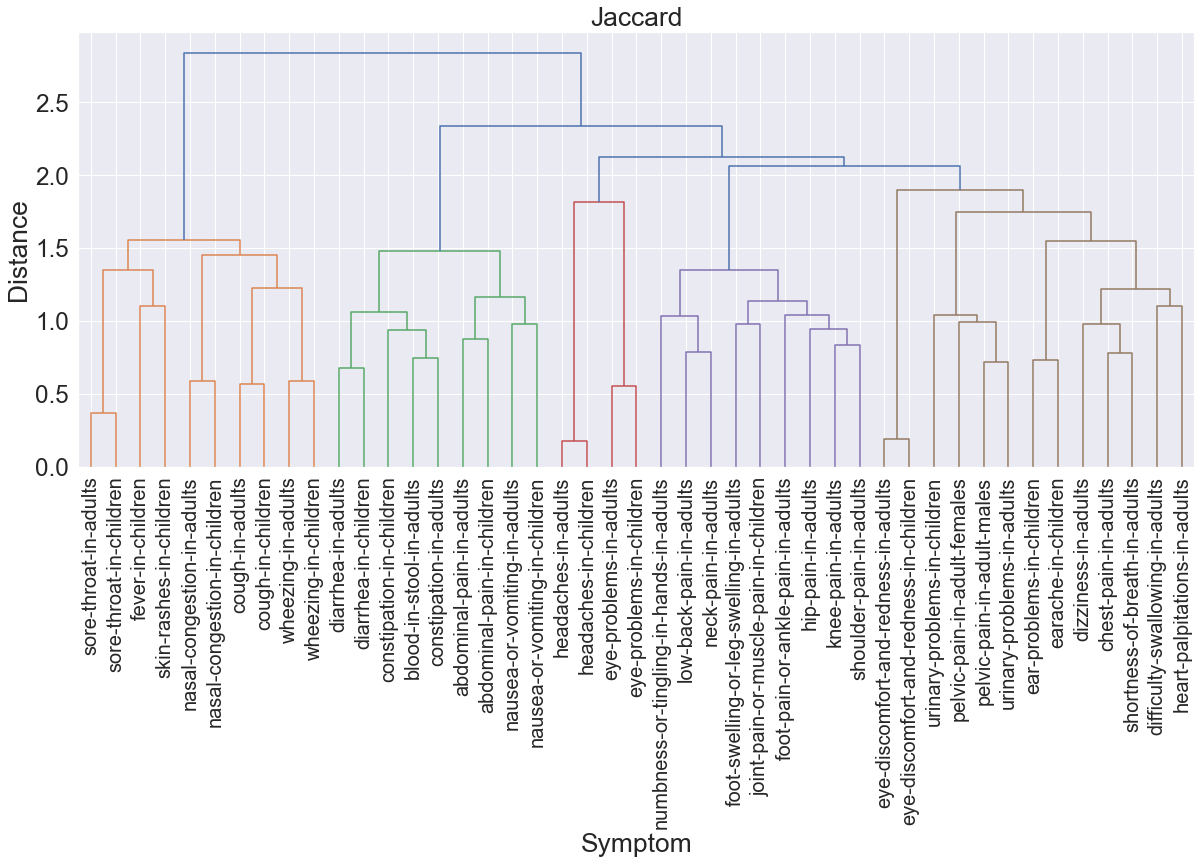

In [ ]:
# Calculate the pairwise Jaccard distance matrix
jaccard_distance_matrix = pairwise_distances(doc_term_matrix.toarray(), metric='jaccard')

# Print the pairwise Jaccard distance matrix
print(jaccard_distance_matrix)

# Create heatmap for Jaccard
sns.set(font_scale=2.2)
sns.heatmap(jaccard_distance_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Jaccard')
plt.show()

# Create dendrogram for cosine
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(jaccard_distance_matrix, method='ward'), labels=f_names)
plt.xticks(fontsize=20)
plt.title('Jaccard')
plt.xlabel('Symptom')
plt.ylabel('Distance')
plt.show()

In [ ]:
text = []
corpus = []
for filename in os.listdir('D:/University/1-Calgary/NLP/Assignment/project/test'):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join('D:/University/1-Calgary/NLP/Assignment/project/test', filename), 'r') as f:
            for line in f: 
                text.append(re.sub(r'\n', '', line))
        corpus.append(text)
        text = []
            

doc1 = corpus[0]
doc2 = corpus[1]

# Calculate cosine similarity
vect = TfidfVectorizer()
tfidf1 = vect.fit_transform(doc1)
tfidf2 = vect.transform(doc2)

similarity = cosine_similarity(tfidf1, tfidf2)

# Find similar filenames
threshold = 0.6

similar_pages= {}
second_source = []

for i, j in zip(*similarity.nonzero()):
    if similarity[i, j] > threshold:
        print(f'{doc1[i]} / {doc2[j]}')
        second_source.append(doc2[j])
        if doc1[i] in similar_pages:
            similar_pages[f'{doc1[i]}'].append(doc2[j]) 
        else:
            similar_pages[f'{doc1[i]}'] = [doc2[j]]
        
similar_pages

In [ ]:
symptom_names = (set(second_source))
symptom_names

In [ ]:
# defining the base URL
base_url = 'https://www.healthychildren.org/English/tips-tools/symptom-checker/Pages'
# creating the URI 
symptom_urls = [base_url+'/symptomviewer.aspx?symptom='+name for name in [re.sub(r' ', '+', page) for page in set(second_source)]]

for i, url in enumerate(symptom_urls):
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    symptom = str(soup.find('div', {'class': 'symptom-summary-content'}))
    #preprocessing the text before adding into txt file
    symptom = re.sub('<.*?>', ' ', symptom)
    words = symptom.split() 
    symptom = " ".join(words[2:]) 
    
    if symptom is not None:
        name = list(symptom_names)[i]
        filename = f'{name}.txt'
        with open(f"D:/University/1-Calgary/NLP/Assignment/project/validation_corpus/{filename}", 'w') as f:
            f.write(re.sub('<.*?>', '', symptom ))
    else:
        print(f"No 'child' section found on page {i+1}")

In [ ]:
dir_path = 'D:/University/1-Calgary/NLP/Assignment/project/validation_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
# new_corpus = []
# for file_name in file_names:
#     with open(os.path.join(dir_path, file_name), 'r') as f:
#         text = f.read()
#         new_corpus.append(text)

# # Calculate TF-IDF matrix
# # vectorizer = TfidfVectorizer()
# tfidf_matrix2 = vectorizer.fit_transform(new_corpus)

# # Compute cosine similarity between all documents
# similarity_matrix2 = cosine_similarity(tfidf_matrix2)

# # # Print similarity matrix.                                                                                                                                                                                                                                                                                     
# print(similarity_matrix2)
# # len(new_corpus)

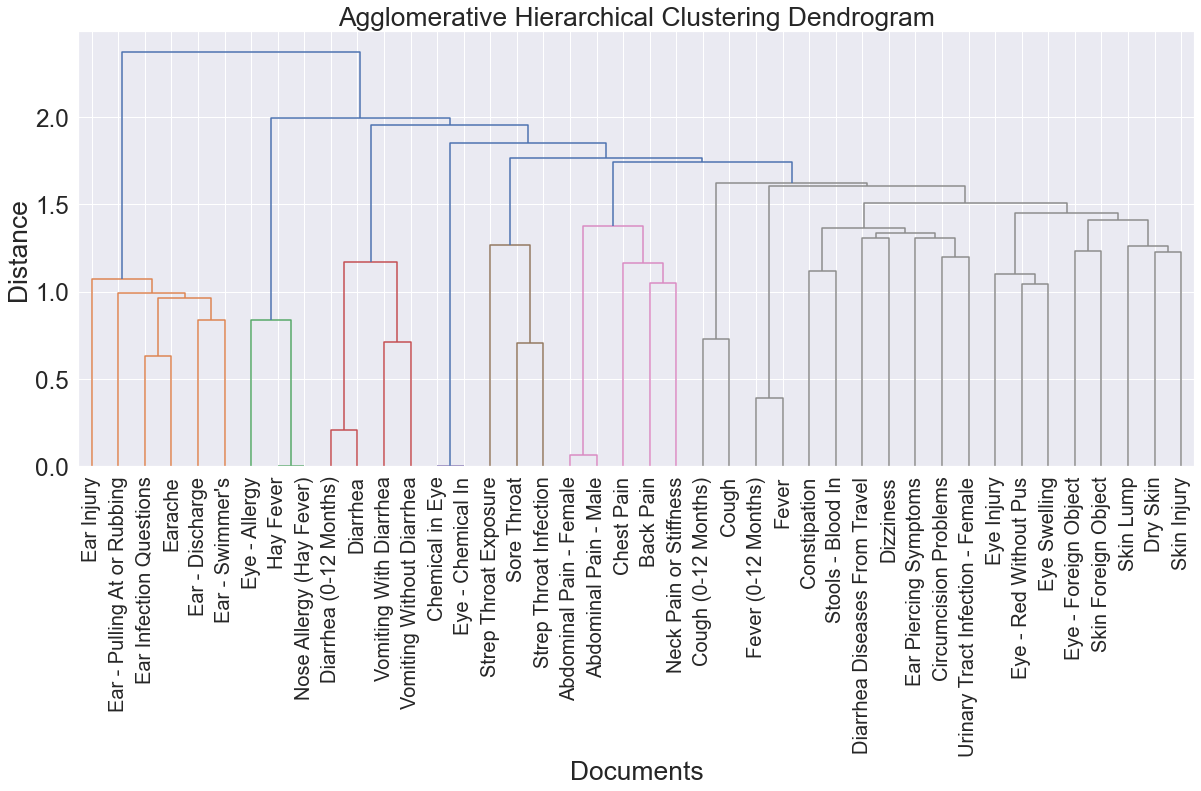

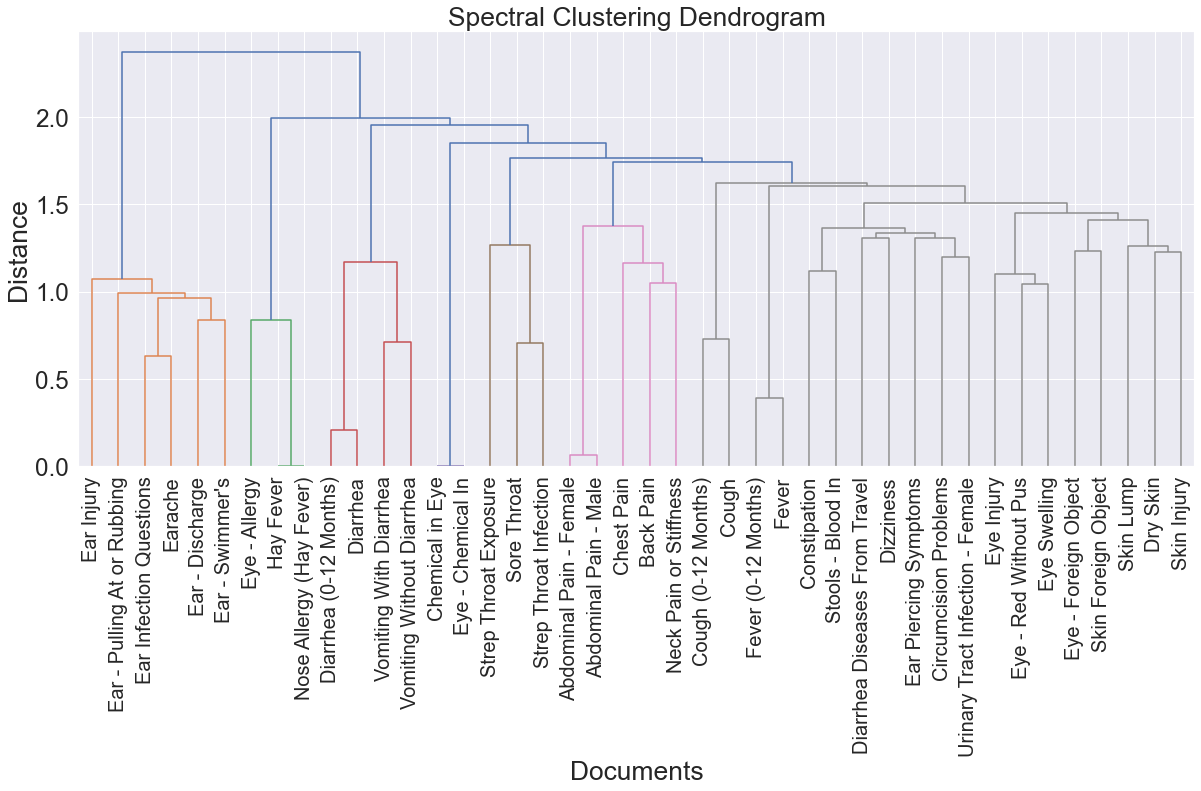

In [ ]:
import os
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# set the path to the folder containing the documents
folder_path = 'D:/University/1-Calgary/NLP/Assignment/project/validation_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# define a function to preprocess the text
def preprocess_text(text):
    # remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # convert to lowercase
    text = text.lower()
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text

# read the documents from the folder and preprocess them
docs = []
for file_name in os.listdir(folder_path):
    with open(os.path.join(folder_path, file_name), 'r') as file:
        doc = file.read()
        doc = preprocess_text(doc)
        docs.append(doc)

# create a tf-idf matrix for the documents
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

# perform clustering using Agglomerative Hierarchical Clustering
# agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_clustering.fit_predict(tfidf_matrix.toarray())
agg_labels = agg_clustering.labels_

# create a dendrogram for Agglomerative Hierarchical Clustering
agg_linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram(agg_linkage_matrix, labels= f_names)
plt.xticks(fontsize= 20)
plt.title("Agglomerative Hierarchical Clustering Dendrogram")
plt.xlabel("Documents")
plt.ylabel("Distance")
plt.show()

# perform clustering using Spectral Clustering
f_names = [i.split('.')[0] for i in file_names]
# spectral_clustering = SpectralClustering(n_clusters=4, assign_labels='kmeans', affinity='nearest_neighbors')
spectral_clustering.fit_predict(tfidf_matrix)
spectral_labels = spectral_clustering.labels_

# create a dendrogram for Spectral Clustering
spectral_linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')
plt.figure(figsize=(20, 8))
dendrogram(spectral_linkage_matrix, labels= f_names)
plt.xticks(fontsize= 20)
plt.title("Spectral Clustering Dendrogram")
plt.xlabel("Documents")
plt.ylabel("Distance")
plt.show()
